
Test the functions related to getCommunities().

@author: Guihong Wan and Boshen Yan      
@date: July 20, 2023

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import anndata as ad
import statistics

In [19]:
import spacells as spc

In [20]:
np.random.seed(42)
print(ad.__version__)

0.9.1


# Read data

In [21]:
adata = ad.read('../spacells/data/example_adata.h5ad')
gate_file = "../spacells/data/example_gates.csv"
adata.obs["id"] = adata.obs_names

The following steps compute the communities based on SOX10+ or CD45+ cells.

In [22]:
adata

AnnData object with n_obs × n_vars = 137816 × 7
    obs: 'X_centroid', 'Y_centroid', 'id'
    uns: 'all_markers'

In [23]:
print(list(adata.var_names))

['SOX10', 'CD8A', 'CD3E', 'CD45', 'panCK', 'CD4', 'aSMA']


In [24]:
markders_of_interest = ["SOX10","CD45"]

# setGate or setGates

In [25]:
spc.prep.setGate(adata, "SOX10", 7.5, debug = True)
spc.prep.setGate(adata, "CD45", 8.0, debug = True)

SOX10_b
False    91523
True     46293
Name: count, dtype: int64
CD45_b
False    98518
True     39298
Name: count, dtype: int64


In [26]:
spc.prep.setGates(adata, gate_file, debug = True)

gate: 7.5 SOX10_b
False    91523
True     46293
Name: count, dtype: int64
gate: 7.0 CD8A_b
False    116836
True      20980
Name: count, dtype: int64
gate: 7.2 CD3E_b
False    111855
True      25961
Name: count, dtype: int64
gate: 8.0 CD45_b
False    98518
True     39298
Name: count, dtype: int64
gate: 6.5 panCK_b
False    129174
True       8642
Name: count, dtype: int64
gate: 7.4 CD4_b
False    113595
True      24221
Name: count, dtype: int64
gate: 5.7 aSMA_b
False    129847
True       7969
Name: count, dtype: int64


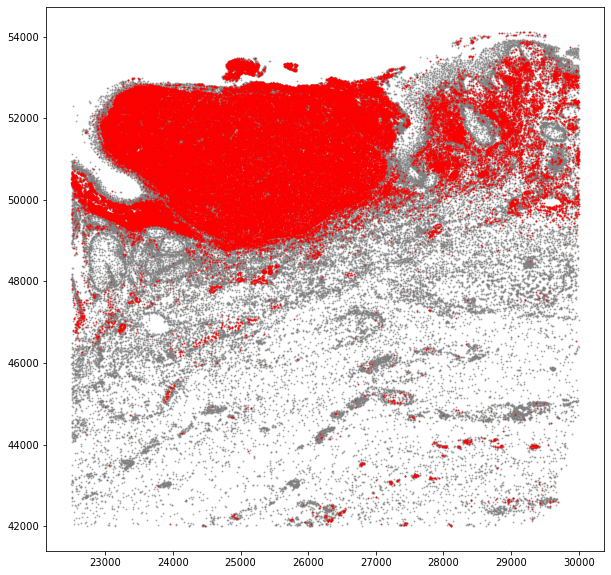

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="grey", alpha=0.5)

tmp = adata[adata.obs.SOX10_b]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

tmp = adata[adata.obs.CD45_b]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=1, color="red", alpha=0.5)

plt.show()

# estimateInitialDistance

In [28]:
# Downsampling is desired; otherwise slow
# Use for estimating the eps parameter

# distance_candidates = spc.spatial.estimateInitialDistance(adata, 
#                                               markders_of_interest, 
#                                               sampling_ratio=0.3)
# print(statistics.quantiles(distance_candidates))

# getCommunities

In [29]:
# %%timeit -r1 -n10
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(adata, markders_of_interest, 
                                 eps= 100, 
                                 newcolumn = communitycolumn)


In [30]:
print("number of communiteis:", len(ret[0]))
# print(adata.obs[communitycolumn].value_counts())

number of communiteis: 26


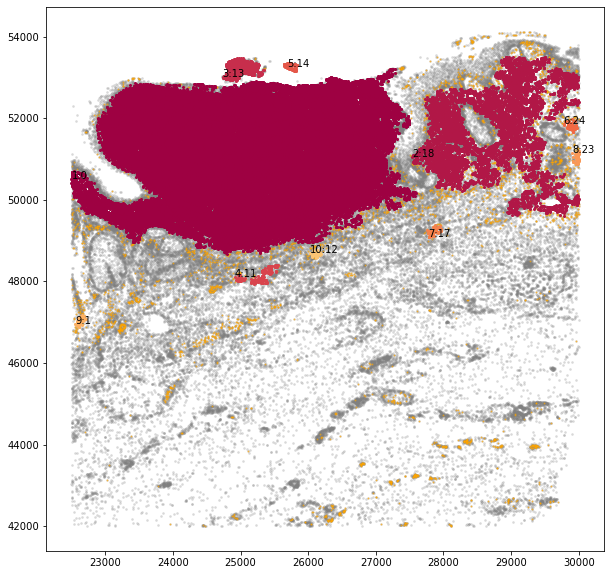

In [31]:
# input: output of getCommunities()
markersize = 2

labels_sorted = ret[0]
db = ret[1]
plot_first_n_clusters = 10

adata_tmp = adata[adata.obs[communitycolumn] > -2]
X = adata_tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(10, 10))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=3, color="grey", alpha=0.2)

# Points of interest: outliers
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# clusters
idx = 0
for npoints, k in labels_sorted:
    if k == -1:
        continue
    if idx >= plot_first_n_clusters:
        break
        
    col = colors[idx] 
    class_member_mask = labels == k
    mask = class_member_mask & core_samples_mask
    xy = X[mask]
    plt.plot(xy[:, 0],xy[:, 1],
             "o",
             markerfacecolor=tuple(col),
             markeredgecolor=tuple(col),
             markersize=markersize,
            )
    # idx: the "idx" largest cluster
    # k: the cluster
    plt.annotate(str(idx+1)+":"+str(k), (xy[0, 0], xy[0, 1]))

    idx += 1

plt.show()
 

In [32]:
clusters_idx_sorted = [idx for npoints, idx in ret[0]]
print(clusters_idx_sorted[:plot_first_n_clusters])
print(ret[0][:plot_first_n_clusters])

[0, 18, 13, 11, 14, 24, 17, 23, 1, 12]
[(68743, 0), (8580, 18), (1222, 13), (217, 11), (161, 14), (97, 24), (75, 17), (67, 23), (62, 1), (59, 12)]


In [34]:
# Here, we choose the three largest ones of interest
communityIndexList = [0, 18, 13]

# Boundary, ExtendedBoundary, ShrunkenBoundary

In [39]:
# If a component is with less than nedges_min, it will be removed.
nedges_min = 20
boundaries = spc.spatial.getBoundary(adata, 
                         communitycolumn, communityIndexList,
                         alpha=80, 
                         nedges_min = nedges_min, nedges_out_min = nedges_min) 


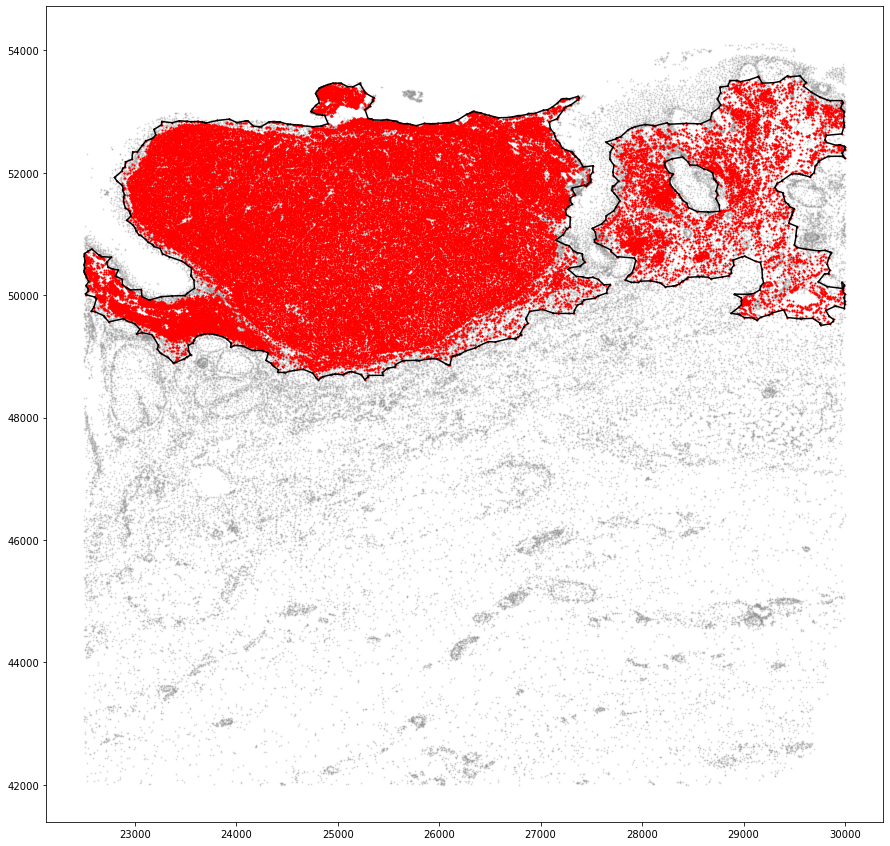

In [40]:
markersize = 1

fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

# Bounds of points in selected commnities
for ed in boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="k")

plt.show()

In [41]:
extended_boundaries = spc.spatial.getExtendedBoundary(boundaries, 
                                          offset=500, 
                                          alpha=100)


In [43]:
shrunken_boundaries = spc.spatial.getShrunkenBoundary(boundaries, 
                                          offset=250, # bugs when offset is too small
                                          alpha=70) # bugs when offset is too small
# Please adjust the parameter based on the visualization below.

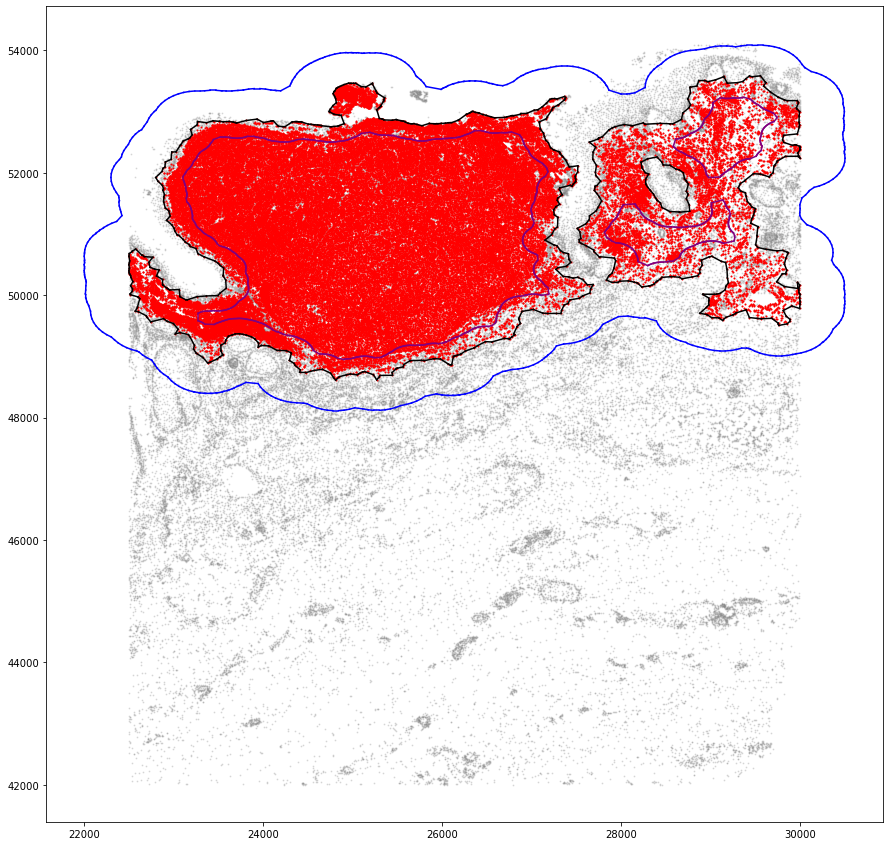

In [44]:
pointsize = 1
fig, ax = plt.subplots(figsize=(15, 15))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")

# Bounds of points in selected commnities
for ed in boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="k")

for ed in extended_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")

for ed in shrunken_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")

plt.show()

# assignPointsToRegion

In [46]:
# This is slow especially when there are a lot of cells

# boundaries
# shrunken_boundaries
# extended_boundaries

# We first work on checking cells that are in shrunken_boundaries;
# Once these cells are known in "0In"; we do not check them again, completed by using donelist


In [47]:
regions = ["0In", "1Bi", "2Bo", "3Out"]
newcolumn = "region"

adata.obs[newcolumn] = "3Out"
adata.obs[newcolumn] = pd.Categorical(adata.obs[newcolumn], 
                                     categories=regions, ordered=True)


In [48]:
# 0In
target = "0In"
donelist = [target]
_ = spc.spatial.assignPointsToRegion(adata, shrunken_boundaries, 
                                     assigncolumn = newcolumn,
                                     target=target, donelist=donelist)


Assigning a region for each cell...
Finish assigning.


In [51]:
# 1Bi
target = "1Bi"
donelist = ["0In", target]

_ = spc.spatial.assignPointsToRegion(adata, boundaries, 
                                     assigncolumn = newcolumn,
                                     target=target, donelist=donelist)

Assigning a region for each cell...
Finish assigning.


In [52]:
# 2Bo
target = "2Bo"
donelist = ["0In", "1Bi", target]

_ = spc.spatial.assignPointsToRegion(adata, extended_boundaries, 
                         assigncolumn = newcolumn,
                         target=target, donelist=donelist)

Assigning a region for each cell...
Finish assigning.


In [53]:
print(set(adata.obs['region']))
print(adata.obs['region'].value_counts())

{'3Out', '0In', '2Bo', '1Bi'}
region
0In     59618
1Bi     35473
3Out    26666
2Bo     16059
Name: count, dtype: int64


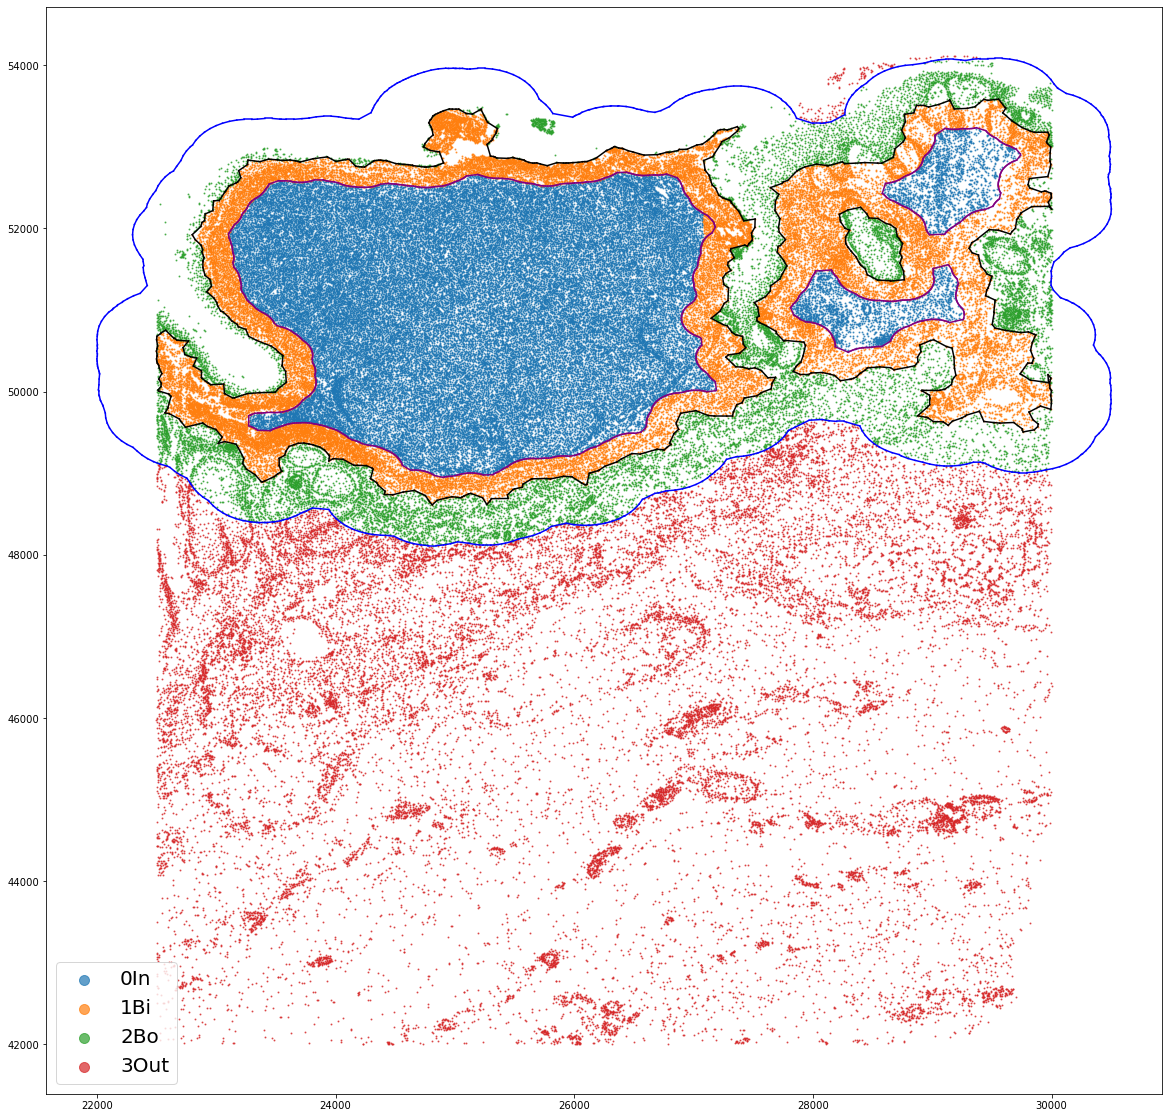

In [56]:

point_size = 1
fig, ax = plt.subplots(figsize=(20, 20))

for region in sorted(set(adata.obs['region'])):
    tmp = adata[adata.obs.region==region]
    ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, alpha=0.7, label = region)

for ed in boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="k")

for ed in extended_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="blue")

for ed in shrunken_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")


plt.legend(loc="lower left", markerscale=10, fontsize=20)
plt.show()